In [2]:
include("EMREfunctionsCompleteSS.jl");

  Activating project at `~/Documents/EMRE Julia Package`


In [3]:
function createSubSpecies(symbol::Symbol, voxelNum::Int)
    subSymbol =  string(string(symbol)[1], string(voxelNum))
    return Symbol(subSymbol)
end;

In [4]:
function createSubRate(symbol::Symbol, voxelNum::Int)
    subSymbol =  string(string(symbol), string(voxelNum))
    return Symbol(subSymbol)
end;

In [5]:
function createSubDiffRate(symbol::Symbol)
    subSymbol =  string("d", string(symbol))
    return Symbol(subSymbol)
end;

In [6]:
struct VoxelReaction
    rxn::Reaction
    voxelNums::Vector{Int}
    voxelRates::Vector{Float64}
end

In [7]:
struct VoxelSpecies
    speciesName::Num
    voxelsNums::Vector{Int}
    initConds::Vector{Float64}
end;


In [8]:
struct DiffReaction
    speciesName::Num
    voxelPairs::Vector{}
    voxelRates::Vector{Float64}
end;

In [9]:
@kwdef struct SpatialSystem
    sysSpecies::Vector{VoxelSpecies}
    sysReactions::Vector{VoxelReaction}
    sysDiffReactions::Vector{DiffReaction}
    numVoxels::Int
end;

In [10]:
## adds all subspecies of a given species to appropriate voxels
function addSpecies(rn::ReactionSystem, species::VoxelSpecies, icsDict)
    i = 1;
    for voxelNum in species.voxelsNums
        subSpeciesSymb = createSubSpecies(Symbol(species.speciesName), voxelNum)
        subSpecies = (@species ($subSpeciesSymb)(t))[1]
        
        addspecies!(rn, subSpecies)
        icsDict[subSpecies] = species.initConds[i]
        i += 1
    end;
end;

In [11]:
## adds reaction (non-diffusive) to appropriate voxels
function addSystemReaction(rn::ReactionSystem, reaction::VoxelReaction, paramsDict)
    i = 1;
    for voxelNum in reaction.voxelNums
        voxelSubstrates = [];
        for substrate in reaction.rxn.substrates
            subSpeciesSymb = createSubSpecies(Symbol(substrate), voxelNum)
            subSpecies = (@species ($subSpeciesSymb)(t))[1]
            push!(voxelSubstrates, subSpecies)
            addspecies!(rn, subSpecies)
        end;
        voxelProducts = [];
        for product in reaction.rxn.products
            prodSpeciesSymb = createSubSpecies(Symbol(product), voxelNum)
            prodSpecies = (@species ($prodSpeciesSymb)(t))[1]
            push!(voxelProducts, prodSpecies)
            addspecies!(rn, prodSpecies)
        end;

        if length(reaction.voxelRates) == 1
            react = Reaction(reaction.rxn.rate, voxelSubstrates, voxelProducts, reaction.rxn.substoich, reaction.rxn.prodstoich)
            addreaction!(rn, react)
            addparam!(rn, reaction.rxn.rate)
            paramsDict[reaction.rxn.rate] = reaction.voxelRates[1]
        else
            rateSymb = createSubRate(Symbol(reaction.rxn.rate), voxelNum)
            rate = (@parameters $rateSymb)[1]
            react = Reaction(rate, voxelSubstrates, voxelProducts, reaction.rxn.substoich, reaction.rxn.prodstoich)
            addreaction!(rn, react)
            addparam!(rn, rate)
            paramsDict[rate] = reaction.voxelRates[i]
        end;
        i += 1
    end;
    addparam!(rn, reaction.rxn.rate); ## assuming rate is the same across voxels, move up into for loop if this changes to different rates
end;

In [12]:
## adds diffusion reactions for a species to appropriate voxels
function addSpeciesDiffusion(rn::ReactionSystem, diff::DiffReaction, paramsDict)
    i = 1;
    for pair in diff.voxelPairs
        subSpeciesSymb1 = createSubSpecies(Symbol(diff.speciesName), pair[1]);
        subSpecies1 = (@species ($subSpeciesSymb1)(t))[1];
        subSpeciesSymb2 = createSubSpecies(Symbol(diff.speciesName), pair[2]);
        subSpecies2 = (@species ($subSpeciesSymb2)(t))[1];
    
        addspecies!(rn, subSpecies1);
        addspecies!(rn, subSpecies2);

        rateSymb = createSubDiffRate(Symbol(diff.speciesName));

        if length(diff.voxelRates) == 1
            rate = (@parameters $rateSymb)[1]
            react1 = Reaction(rate, [subSpecies1], [subSpecies2]);
            addreaction!(rn, react1);
            addparam!(rn, rate);
            paramsDict[rate] = diff.voxelRates[1]

            if pair[3] == true ## if diffusion is bidirectional
                react2 = Reaction(rate, [subSpecies2], [subSpecies1]);
                addreaction!(rn, react2);
            end;
        else
            ## can't do this yet
        end;
    end;
end;

In [13]:
function buildSystem(sys::SpatialSystem)

    rn = @reaction_network begin
    end;

    icsDict = Dict([]);
    paramsDict = Dict([]);

    for species in sys.sysSpecies
        addSpecies(rn, species, icsDict)
    end;
    for rx in sys.sysReactions
        addSystemReaction(rn, rx, paramsDict)
    end;
    for dRx in sys.sysDiffReactions
        addSpeciesDiffusion(rn, dRx, paramsDict)
    end;

    return rn, icsDict, paramsDict;
end;

In [24]:
## a function that builds the spatial system and sets up the ics and params for EMRE functions

# rn, icsDict, paramsDict = buildSystem(sys);
# display(rn.ps)
# ics = [];
# for species in rn.species
#     push!(ics, icsDict[species])
# end;
# params = [];
# for param in rn.ps
#     if param in keys(paramsDict)
#         push!(params, paramsDict[param])
#     else
#         push!(params, 0);
#     end;
# end;

## Testing ##

In [38]:
@species A B C
# @parameters k₁ k₂
@variables t

sys = SpatialSystem(sysSpecies = [
                        VoxelSpecies(A, [1, 2], [4, 2]), 
                        VoxelSpecies(B, [1, 2], [3, 1]),
                        VoxelSpecies(C, [1, 2], [2, 0]) ],
                    sysReactions = [
                        VoxelReaction((@reaction k₁,A + B --> C), [1, 2], [0.7]),
                        VoxelReaction((@reaction k₂,C --> A + B), [1, 2], [0.2])],
                    sysDiffReactions = [
                        DiffReaction(A, [[1, 2, true]], [0.3]),
                        DiffReaction(B, [[1, 2, true]], [0.3]),
                        DiffReaction(C, [[1, 2, true]], [0.3])],
                    numVoxels = 2,
);

In [41]:
rn, icsDict, paramsDict = buildSystem(sys);
ics = [];
for species in rn.species
    push!(ics, icsDict[species]);
end;
params = [];
for param in rn.ps
    if param in keys(paramsDict)
        push!(params, paramsDict[param]);
    else
        push!(params, 0)
    end;
end;

tEnd = 100; numSteps = 101; numTrajs = 1000;
volume = 1/(sys.numVoxels);
timePoints, SSAmeans, SS, realizedSS = EMRE(rn, ics, params, volume, tEnd, numSteps, numTrajs);

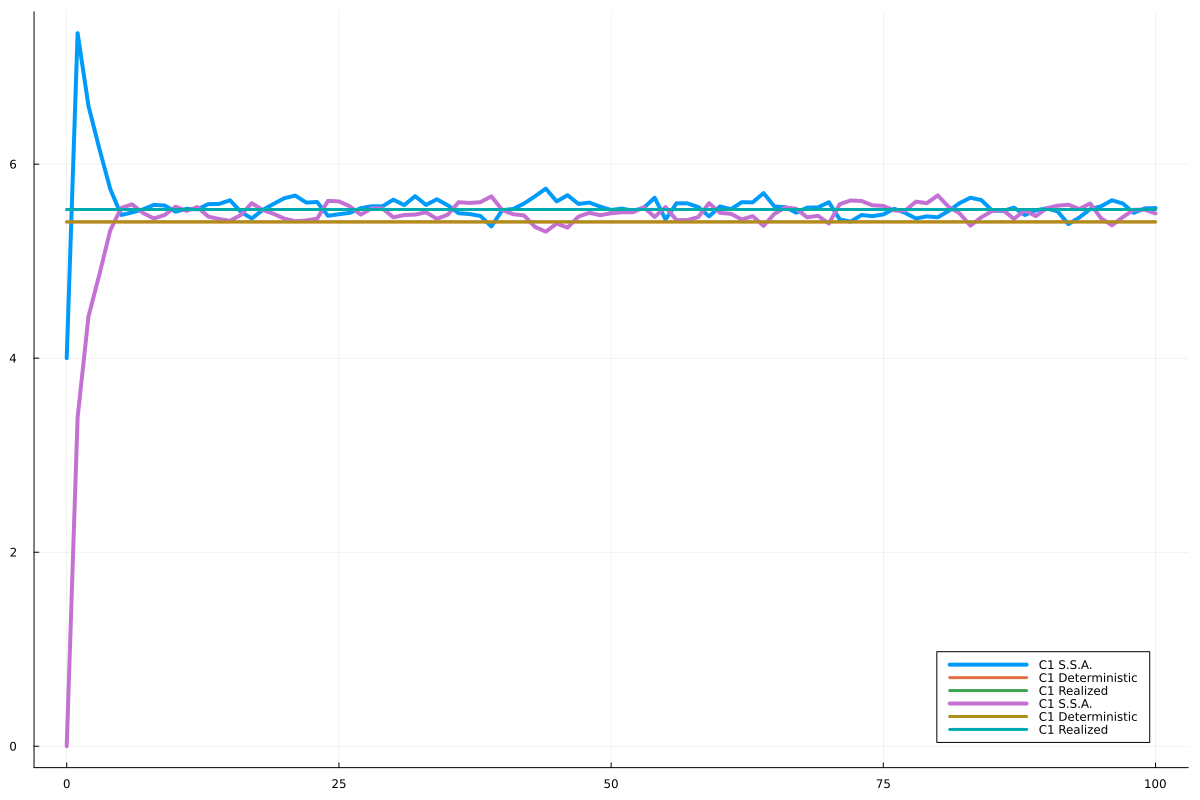

In [40]:
plot(timePoints, [array[5] for array in SSAmeans], lw=4, label="C1 S.S.A.", size=(1200,800))
plot!([0, tEnd], [SS[5], SS[5]], lw=3, label="C1 Deterministic")
plot!([0, tEnd], [realizedSS[5], realizedSS[5]], lw=3, label="C1 Realized")
plot!(timePoints, [array[6] for array in SSAmeans], lw=4, label="C1 S.S.A.", size=(1200,800))
plot!([0, tEnd], [SS[6], SS[6]], lw=3, label="C1 Deterministic")
plot!([0, tEnd], [realizedSS[6], realizedSS[6]], lw=3, label="C1 Realized")